<a href="https://colab.research.google.com/github/NazmulHassan033/Nazmul-Hassan/blob/main/ANN_Final_unbalanced_data_handling_an_proposal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# In this notebook is demonstrated an proposal for treatment of imbalanced data
# import of needed libraries
import numpy as np
import pandas as pd
from scipy.sparse import *
from sklearn.metrics.pairwise import pairwise_distances
from sklearn import preprocessing

import seaborn as sns

# evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

# classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# read dataset
data_origin = pd.read_csv("pd_speech_features.csv")
print(data_origin.shape)
data_origin.head()

(756, 755)


,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,...,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,status
0,0,1,0.85247,0.71826,0.57227,240,239,0.008064,0.000087,0.00218,...,1.5620,2.6445,3.8686,4.2105,5.1221,4.4625,2.6202,3.0004,18.9405,1
1,0,1,0.76686,0.69481,0.53966,234,233,0.008258,0.000073,0.00195,...,1.5589,3.6107,23.5155,14.1962,11.0261,9.5082,6.5245,6.3431,45.1780,1
2,0,1,0.85083,0.67604,0.58982,232,231,0.008340,0.000060,0.00176,...,1.5643,2.3308,9.4959,10.7458,11.0177,4.8066,2.9199,3.1495,4.7666,1
3,1,0,0.41121,0.79672,0.59257,178,177,0.010858,0.000183,0.00419,...,3.7805,3.5664,5.2558,14.0403,4.2235,4.6857,4.8460,6.2650,4.0603,1
4,1,0,0.32790,0.79782,0.53028,236,235,0.008162,0.002669,0.00535,...,6.1727,5.8416,6.0805,5.7621,7.7817,11.6891,8.2103,5.0559,6.1164,1


In [ ]:
from sklearn.model_selection import train_test_split
# Separate features (X) and target variable (y)
dataset = data_origin
X = dataset.drop(['id','status'], axis=1)
y = dataset['status']

# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Create the base estimator (Decision Tree Classifier) for SMOTEBoost
base_estimator = DecisionTreeClassifier(random_state=42)


In [ ]:
from collections import Counter

import numpy as np
from sklearn.base import is_regressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble._forest import BaseForest
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
from sklearn.tree import BaseDecisionTree
from sklearn.utils import check_random_state
from sklearn.utils import check_X_y
#from sklearn.utils import shuffle


class SMOTE(object):
    """Implementation of Synthetic Minority Over-Sampling Technique (SMOTE).

    SMOTE performs oversampling of the minority class by picking target
    minority class samples and their nearest minority class neighbors and
    generating new samples that linearly combine features of each target
    sample with features of its selected minority class neighbors [1].

    Parameters
    ----------
    k_neighbors : int, optional (default=5)
        Number of nearest neighbors.

    random_state : int or None, optional (default=None)
        If int, random_state is the seed used by the random number generator.
        If None, the random number generator is the RandomState instance used
        by np.random.

    References
    ----------
    .. [1] N. V. Chawla, K. W. Bowyer, L. O. Hall, and P. Kegelmeyer. "SMOTE:
           Synthetic Minority Over-Sampling Technique." Journal of Artificial
           Intelligence Research (JAIR), 2002.
    """

    def __init__(self, k_neighbors=5, random_state=None):
        self.k = k_neighbors
        self.random_state = random_state

    def sample(self, n_samples):
        """Generate samples.

        Parameters
        ----------
        n_samples : int
            Number of new synthetic samples.

        Returns
        -------
        S : array, shape = [n_samples, n_features]
            Returns synthetic samples.
        """
        np.random.seed(seed=self.random_state)

        S = np.zeros(shape=(n_samples, self.n_features))
        # Calculate synthetic samples.
        for i in range(n_samples):
            j = np.random.randint(0, self.X.shape[0])

            # Find the NN for each sample.
            # Exclude the sample itself.
            nn = self.neigh.kneighbors(
                self.X[j].reshape(1, -1), return_distance=False
            )[:, 1:]
            nn_index = np.random.choice(nn[0])

            dif = self.X[nn_index] - self.X[j]
            gap = np.random.random()

            S[i, :] = self.X[j, :] + gap * dif[:]

        return S

    def fit(self, X):
        """Train model based on input data.

        Parameters
        ----------
        X : array-like, shape = [n_minority_samples, n_features]
            Holds the minority samples.
        """
        self.X = X
        self.n_minority_samples, self.n_features = self.X.shape

        # Learn nearest neighbors.
        self.neigh = NearestNeighbors(n_neighbors=self.k + 1)
        self.neigh.fit(self.X)

        return self


class SMOTEBoost(AdaBoostClassifier):
    """Implementation of SMOTEBoost.

    SMOTEBoost introduces data sampling into the AdaBoost algorithm by
    oversampling the minority class using SMOTE on each boosting iteration [1].

    This implementation inherits methods from the scikit-learn
    AdaBoostClassifier class, only modifying the `fit` method.

    Parameters
    ----------
    n_samples : int, optional (default=100)
        Number of new synthetic samples per boosting step.

    k_neighbors : int, optional (default=5)
        Number of nearest neighbors.

    base_estimator : object, optional (default=DecisionTreeClassifier)
        The base estimator from which the boosted ensemble is built.
        Support for sample weighting is required, as well as proper `classes_`
        and `n_classes_` attributes.

    n_estimators : int, optional (default=50)
        The maximum number of estimators at which boosting is terminated.
        In case of perfect fit, the learning procedure is stopped early.

    learning_rate : float, optional (default=1.)
        Learning rate shrinks the contribution of each classifier by
        ``learning_rate``. There is a trade-off between ``learning_rate`` and
        ``n_estimators``.

    algorithm : {'SAMME', 'SAMME.R'}, optional (default='SAMME.R')
        If 'SAMME.R' then use the SAMME.R real boosting algorithm.
        ``base_estimator`` must support calculation of class probabilities.
        If 'SAMME' then use the SAMME discrete boosting algorithm.
        The SAMME.R algorithm typically converges faster than SAMME,
        achieving a lower test error with fewer boosting iterations.

    random_state : int or None, optional (default=None)
        If int, random_state is the seed used by the random number generator.
        If None, the random number generator is the RandomState instance used
        by np.random.

    References
    ----------
    .. [1] N. V. Chawla, A. Lazarevic, L. O. Hall, and K. W. Bowyer.
           "SMOTEBoost: Improving Prediction of the Minority Class in
           Boosting." European Conference on Principles of Data Mining and
           Knowledge Discovery (PKDD), 2003.
    """

    def __init__(
        self,
        n_samples=100,
        k_neighbors=5,
        base_estimator=None,
        n_estimators=50,
        learning_rate=1.,
        algorithm="SAMME.R",
        random_state=None,
    ):

        self.n_samples = n_samples
        self.algorithm = algorithm
        self.k_neighbors = k_neighbors
        self.smote = SMOTE(k_neighbors=k_neighbors, random_state=random_state)

        super(SMOTEBoost, self).__init__(
            base_estimator=base_estimator,
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            random_state=random_state,
        )

    def fit(self, X, y, sample_weight=None, minority_target=None):
        """Build a boosted classifier/regressor from the training set (X, y),
        performing SMOTE during each boosting step.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape = [n_samples, n_features]
            The training input samples. Sparse matrix can be CSC, CSR, COO,
            DOK, or LIL. COO, DOK, and LIL are converted to CSR. The dtype is
            forced to DTYPE from tree._tree if the base classifier of this
            ensemble weighted boosting classifier is a tree or forest.

        y : array-like of shape = [n_samples]
            The target values (class labels in classification, real numbers in
            regression).

        sample_weight : array-like of shape = [n_samples], optional
            Sample weights. If None, the sample weights are initialized to
            1 / n_samples.

        minority_target : int
            Minority class label.

        Returns
        -------
        self : object
            Returns self.

        Notes
        -----
        Based on the scikit-learn v0.18 AdaBoostClassifier and
        BaseWeightBoosting `fit` methods.
        """
        # Check that algorithm is supported.
        if self.algorithm not in ("SAMME", "SAMME.R"):
            raise ValueError("algorithm %s is not supported" % self.algorithm)

        # Check parameters.
        if self.learning_rate <= 0:
            raise ValueError("learning_rate must be greater than zero")

        if (self.base_estimator is None or isinstance(
            self.base_estimator, (BaseDecisionTree, BaseForest)
        )):
            DTYPE = np.float64  # from fast_dict.pxd
            dtype = DTYPE
            accept_sparse = "csc"
        else:
            dtype = None
            accept_sparse = ["csr", "csc"]

        X, y = check_X_y(
            X,
            y,
            accept_sparse=accept_sparse,
            dtype=dtype,
            y_numeric=is_regressor(self),
        )

        if sample_weight is None:
            # Initialize weights to 1 / n_samples.
            sample_weight = np.empty(X.shape[0], dtype=np.float64)
            sample_weight[:] = 1. / X.shape[0]
        else:
            sample_weight = check_array(sample_weight, ensure_2d=False)
            # Normalize existing weights.
            sample_weight = sample_weight / sample_weight.sum(dtype=np.float64)

            # Check that the sample weights sum is positive.
            if sample_weight.sum() <= 0:
                raise ValueError(
                    "Attempting to fit with a non-positive "
                    "weighted number of samples."
                )

        if minority_target is None:
            # Determine the minority class label.
            stats_c_ = Counter(y)
            min_c_ = min(stats_c_, key=stats_c_.get)
            self.minority_target = min_c_
        else:
            self.minority_target = minority_target

        # Check parameters.
        self._validate_estimator()

        # Clear any previous fit results.
        self.estimators_ = []
        self.estimator_weights_ = np.zeros(self.n_estimators, dtype=np.float64)
        self.estimator_errors_ = np.ones(self.n_estimators, dtype=np.float64)

        random_state = check_random_state(self.random_state)

        for iboost in range(self.n_estimators):
            X_min = X[np.where(y == self.minority_target)]

            # SMOTE step.
            if len(X_min) >= self.smote.k:
                self.smote.fit(X_min)
                X_syn = self.smote.sample(self.n_samples)
                y_syn = np.full(
                    X_syn.shape[0],
                    fill_value=self.minority_target,
                    dtype=np.int64,
                )

                # Normalize synthetic sample weights based on current training set.
                sample_weight_syn = np.empty(X_syn.shape[0], dtype=np.float64)
                sample_weight_syn[:] = 1. / X.shape[0]

                # Combine the original and synthetic samples.
                X = np.vstack((X, X_syn))
                y = np.append(y, y_syn)

                # Combine the weights.
                sample_weight = np.append(
                    sample_weight, sample_weight_syn
                ).reshape(-1, 1)
                sample_weight = np.squeeze(
                    normalize(sample_weight, axis=0, norm="l1")
                )

                #X, y, sample_weight = shuffle(
                #    X, y, sample_weight, random_state=random_state
                #)

            # Boosting step.
            sample_weight, estimator_weight, estimator_error = self._boost(
                iboost,
                X,
                y,
                sample_weight,
                random_state,
            )

            # Early termination.
            if sample_weight is None:
                break

            self.estimator_weights_[iboost] = estimator_weight
            self.estimator_errors_[iboost] = estimator_error

            # Stop if error is zero.
            if estimator_error == 0:
                break

            sample_weight_sum = np.sum(sample_weight)

            # Stop if the sum of sample weights has become non-positive.
            if sample_weight_sum <= 0:
                break

            if iboost < self.n_estimators - 1:
                # Normalize.
                sample_weight /= sample_weight_sum

        return self

In [ ]:
from collections import Counter

# Assuming y_train is your target variable
class_counts = Counter(y_train)
print(class_counts)


Counter({1: 103, 0: 33})


In [ ]:
minority_class = min(class_counts, key=class_counts.get)
print("Minority Class Label:", minority_class)


Minority Class Label: 0


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


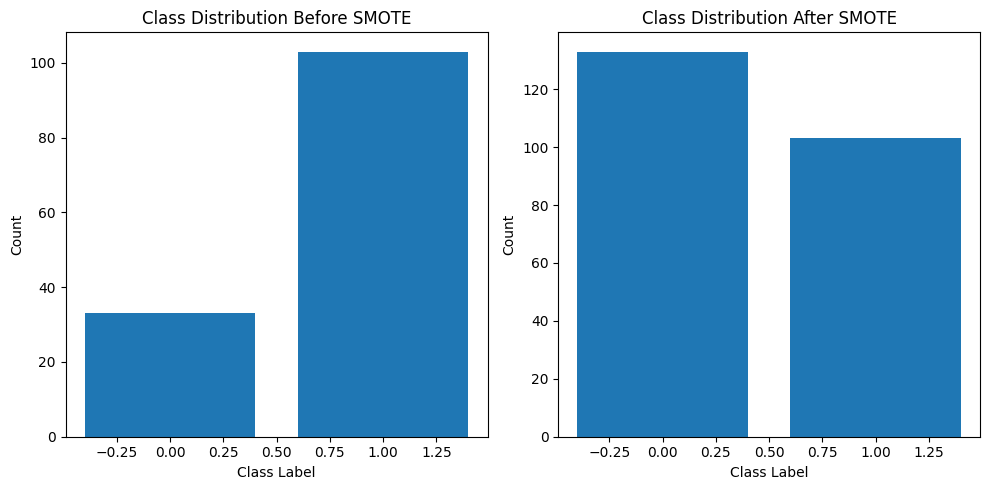

In [ ]:
import matplotlib.pyplot as plt

# Count the occurrences of each class in the original data
class_counts_before = y_train.value_counts()
minority_target_label = 0
# Create the base estimator (e.g., DecisionTreeClassifier)
base_estimator = DecisionTreeClassifier(random_state=42)

# Create the SMOTEBoost classifier
smoteboost_model = SMOTEBoost(
    n_samples=100,
    base_estimator=base_estimator,
    n_estimators=50,
    learning_rate=1.0,
    algorithm="SAMME.R",
    random_state=42,
)

# Fit the SMOTEBoost model to the training data with the minority target label
smoteboost_model.fit(X_train, y_train, minority_target=minority_target_label)

# Generate synthetic samples using SMOTE
X_train_synthetic = smoteboost_model.smote.sample(100)

# Combine the original and synthetic samples
X_combined = np.vstack((X_train, X_train_synthetic))
y_combined = np.concatenate((y_train, np.full(len(X_train_synthetic), fill_value=minority_target_label)))

# Count the occurrences of each class after applying SMOTE
class_counts_after = pd.Series(y_combined).value_counts()

# Plot the class distribution before and after SMOTE
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(class_counts_before.index, class_counts_before.values)
plt.title('Class Distribution Before SMOTE')
plt.xlabel('Class Label')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.bar(class_counts_after.index, class_counts_after.values)
plt.title('Class Distribution After SMOTE')
plt.xlabel('Class Label')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


#making balanced dataset


In [ ]:
# Generate synthetic samples using SMOTE
X_train_synthetic = smoteboost_model.smote.sample(100)

# Combine the original and synthetic samples
X_combined = np.vstack((X_train, X_train_synthetic))
y_combined = np.concatenate((y_train, np.full(len(X_train_synthetic), fill_value=minority_target_label)))

# Create a new dataset with a different name
new_X_train = X_combined
new_y_train = y_combined


#balanced dataset

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming you have already trained the SMOTEBoost model and obtained the balanced data
# new_X_train and new_y_train are the balanced features and labels, respectively.

# Combine new_X_train and new_y_train into a pandas DataFrame
balanced_data = pd.DataFrame(data=np.hstack((new_X_train, new_y_train.reshape(-1, 1))),
                             columns=[f'feature_{i}' for i in range(new_X_train.shape[1])] + ['target'])

# Save the balanced dataset to a CSV file
balanced_data.to_csv('balanced_dataset.csv', index=False)


#Combined dataset


In [ ]:
import pandas as pd

# Assuming you have already created new_X_train and new_y_train

# Combine new_X_train and new_y_train into a pandas DataFrame
combined_data = pd.DataFrame(data=np.hstack((new_X_train, new_y_train.reshape(-1, 1))),
                             columns=[f'feature_{i}' for i in range(new_X_train.shape[1])] + ['target'])

# Save the combined dataset to a CSV file
combined_data.to_csv('combined_dataset.csv', index=False)


In [ ]:
# Replace <your_minority_class_label> with the actual label of your minority class
minority_target_label = 0

# Create the base estimator (e.g., DecisionTreeClassifier)
base_estimator = DecisionTreeClassifier(random_state=42)

# Create the SMOTEBoost classifier
smoteboost_model = SMOTEBoost(
    n_samples=100,
    k_neighbors=5,
    base_estimator=base_estimator,
    n_estimators=50,
    learning_rate=1.0,
    algorithm="SAMME.R",
    random_state=42,
)

# Fit the SMOTEBoost model to the training data with the minority target label
smoteboost_model.fit(X_train, y_train, minority_target=minority_target_label)


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


SMOTEBoost(base_estimator=DecisionTreeClassifier(random_state=42),
           random_state=42)

In [ ]:
# Fit the SMOTEBoost model to the training data with the minority target label
smoteboost_model.fit(X_train, y_train, minority_target=minority_target_label)


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


SMOTEBoost(base_estimator=DecisionTreeClassifier(random_state=42),
           random_state=42)

In [ ]:
# Make predictions on the test data
y_pred = smoteboost_model.predict(X_test)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SMOTEBoost was fitted without feature names
  warnings.warn(


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Evaluate precision
precision = precision_score(y_test, y_pred, average="macro")
print("Precision:", precision)

# Evaluate recall
recall = recall_score(y_test, y_pred, average="macro")
print("Recall:", recall)

# Evaluate F1-score
f1 = f1_score(y_test, y_pred, average="macro")
print("F1-score:", f1)


Accuracy: 0.9
Precision: 0.7307692307692308
Recall: 0.7962962962962963
F1-score: 0.7574123989218329


#Applying ANN to Balanced Data


In [ ]:
# read dataset
data_new = pd.read_csv("balanced_dataset.csv")
print(data_new.shape)
data_new.head()


(236, 23)


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,target
0,180.198,201.249,175.456,0.00284,0.00002,0.00153,0.00166,0.00459,0.01444,0.131,...,0.02177,0.00231,26.738,0.403884,0.766209,-6.452058,0.212294,2.269398,0.141929,1.0
1,199.228,209.512,192.091,0.00241,0.00001,0.00134,0.00138,0.00402,0.01015,0.089,...,0.01513,0.00167,30.940,0.432439,0.742055,-7.682587,0.173319,2.103106,0.068501,0.0
2,113.715,116.443,96.913,0.00349,0.00003,0.00171,0.00203,0.00514,0.01472,0.133,...,0.02245,0.00478,26.547,0.380253,0.766700,-5.943501,0.192150,1.852542,0.179677,0.0
3,136.926,159.866,131.276,0.00293,0.00002,0.00118,0.00153,0.00355,0.01259,0.112,...,0.01968,0.00581,25.703,0.460600,0.646846,-6.547148,0.152813,2.041277,0.138512,1.0
4,193.030,208.900,80.297,0.00766,0.00004,0.00450,0.00389,0.01351,0.03044,0.275,...,0.05312,0.00947,21.934,0.497554,0.740539,-5.845099,0.278679,2.608749,0.185668,1.0


In [ ]:
X_un=data_new.drop(['target'],axis=1)
y_un=data_new[['target']]

In [ ]:
y_un.value_counts()

target
0.0       133
1.0       103
dtype: int64

<Axes: ylabel='target'>

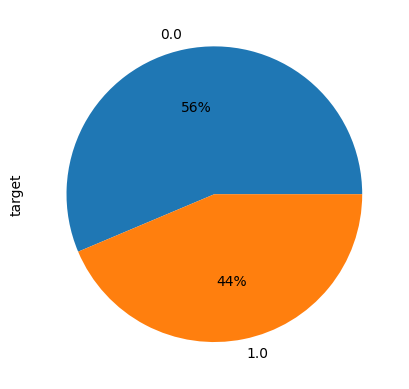

In [ ]:
data_new['target'].value_counts().plot(kind='pie', autopct = "%1.0f%%")

<Axes: >

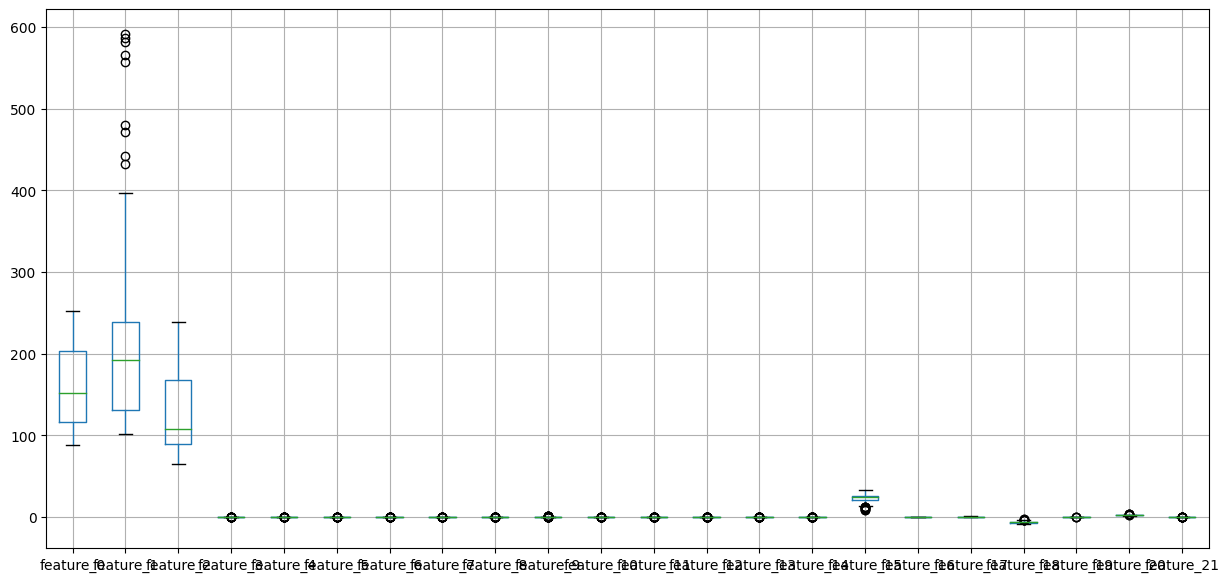

In [ ]:
X_un.boxplot(figsize=(15,7))

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
split=StratifiedShuffleSplit(n_splits=3,test_size=0.2,random_state=24)

for train_index,test_index in split.split(X_un,y_un):
    strat_train_set_x,strat_train_y=X_un.loc[train_index],y_un.loc[train_index]
    strat_test_set_x,strat_test_y=X_un.loc[test_index],y_un.loc[test_index] #completely unseen to our classifier

In [ ]:
print(strat_train_set_x.shape,strat_train_y.shape)
print(strat_test_set_x.shape,strat_test_y.shape)

(188, 22) (188, 1)
(48, 22) (48, 1)


In [ ]:
#Train the model
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report

from xgboost import XGBClassifier
from sklearn.metrics import precision_score, accuracy_score,recall_score
model=XGBClassifier(use_label_encoder=False,eval_metric='rmse')
model.fit(strat_train_set_x,strat_train_y)
y_pred=model.predict(strat_test_set_x)

print('accuracy score %.2f'% accuracy_score(y_pred,strat_test_y))
print('recall score %.2f'%recall_score(y_pred,strat_test_y))


accuracy score 0.88
recall score 0.94


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [ ]:
print("Confusion Matrix: ")
cf_matrix=confusion_matrix(y_pred,strat_test_y)

print("\nClassification Report:")
print(classification_report(y_pred,strat_test_y))

Confusion Matrix: 

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.84      0.90        31
           1       0.76      0.94      0.84        17

    accuracy                           0.88        48
   macro avg       0.86      0.89      0.87        48
weighted avg       0.89      0.88      0.88        48



Confusion Matrix: 

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.84      0.90        31
           1       0.76      0.94      0.84        17

    accuracy                           0.88        48
   macro avg       0.86      0.89      0.87        48
weighted avg       0.89      0.88      0.88        48



<Axes: >

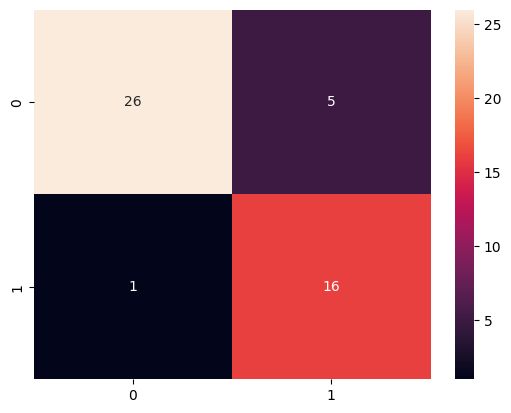

In [ ]:
print("Confusion Matrix: ")
cf_matrix=confusion_matrix(y_pred,strat_test_y)

print("\nClassification Report:")
print(classification_report(y_pred,strat_test_y))


import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

In [ ]:
SEED = 42
EPOCHS = 300
BATCH_SIZE = 32

In [ ]:
import os
for dirname, _, filenames in os.walk('../F:/Thesis Folder/Thesis'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
pip install tensorflow-addons


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 10.3 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:

def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

seed_everything(SEED)

In [ ]:


train_df, test_df = train_test_split(data_new,
                                     test_size=0.2,
                                     random_state=SEED)
train_df, val_df = train_test_split(train_df,
                                    test_size=0.2,
                                    random_state=SEED)


X_train = train_df.drop('target', axis=1).values.astype('float32')
y_train = train_df['target'].values.astype('int32')
X_val = val_df.drop('target', axis=1).values.astype('float32')
y_val = val_df['target'].values.astype('int32')
X_test = test_df.drop('target', axis=1).values.astype('float32')
y_test = test_df['target'].values.astype('int32')

mmsc = MinMaxScaler()
X_train = mmsc.fit_transform(X_train)
X_val = mmsc.transform(X_val)
X_test = mmsc.transform(X_test)

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

#Building the model

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
import tensorflow_addons as tfa
from sklearn.metrics import precision_score, recall_score, f1_score

class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super(MetricsCallback, self).__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        val_predictions = np.argmax(self.model.predict(self.validation_data[0]), axis=-1)
        val_targets = np.argmax(self.validation_data[1], axis=-1)

        precision = precision_score(val_targets, val_predictions, average='macro')
        recall = recall_score(val_targets, val_predictions, average='macro')
        f1 = f1_score(val_targets, val_predictions, average='macro')

        print(f'Precision: {precision:.4f} - Recall: {recall:.4f} - F1: {f1:.4f}')


In [ ]:

shape = X_train.shape[1]
num_classes = y_train.shape[1]

model = Sequential()
model.add(Input((shape,)))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
opt = tfa.optimizers.RectifiedAdam()
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 128)               2944      
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dense_7 (Dense)             (None, 128)               16512     
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 2)                 130       
                                                                 
Total params: 44,354
Trainable params: 44,354
Non-trainable params: 0
_________________________________________________________________


In [ ]:
es_callback = tf.keras.callbacks.EarlyStopping(patience=30, verbose=1, restore_best_weights=True)
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(X_val, y_val), callbacks=[es_callback])

Epoch 1/300
5/5 [==============================] - 1s 48ms/step - loss: 0.6994 - accuracy: 0.5000 - val_loss: 0.6981 - val_accuracy: 0.5263
Epoch 2/300
5/5 [==============================] - 0s 7ms/step - loss: 0.6969 - accuracy: 0.5133 - val_loss: 0.6973 - val_accuracy: 0.5263
Epoch 3/300
5/5 [==============================] - 0s 7ms/step - loss: 0.6900 - accuracy: 0.5733 - val_loss: 0.6957 - val_accuracy: 0.6053
Epoch 4/300
5/5 [==============================] - 0s 8ms/step - loss: 0.6803 - accuracy: 0.6467 - val_loss: 0.6938 - val_accuracy: 0.6053
Epoch 5/300
5/5 [==============================] - 0s 7ms/step - loss: 0.6696 - accuracy: 0.7467 - val_loss: 0.6918 - val_accuracy: 0.6579
Epoch 6/300
5/5 [==============================] - 0s 7ms/step - loss: 0.6572 - accuracy: 0.7933 - val_loss: 0.6902 - val_accuracy: 0.6579
Epoch 7/300
5/5 [==============================] - 0s 8ms/step - loss: 0.6442 - accuracy: 0.8200 - val_loss: 0.6887 - val_accuracy: 0.7105
Epoch 8/300
5/5 [=========

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
import tensorflow_addons as tfa
from sklearn.metrics import precision_score, recall_score, f1_score

class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super(MetricsCallback, self).__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        val_predictions = np.argmax(self.model.predict(self.validation_data[0]), axis=-1)
        val_targets = np.argmax(self.validation_data[1], axis=-1)

        precision = precision_score(val_targets, val_predictions, average='macro')
        recall = recall_score(val_targets, val_predictions, average='macro')
        f1 = f1_score(val_targets, val_predictions, average='macro')

        print(f'Precision: {precision:.4f} - Recall: {recall:.4f} - F1: {f1:.4f}')

shape = X_train.shape[1]
num_classes = y_train.shape[1]

model = Sequential()
model.add(Input((shape,)))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
opt = tfa.optimizers.RectifiedAdam()
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

es_callback = tf.keras.callbacks.EarlyStopping(patience=30, verbose=1, restore_best_weights=True)
metrics_callback = MetricsCallback(validation_data=(X_val, y_val))

history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(X_val, y_val), callbacks=[es_callback, metrics_callback])


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 128)               2944      
                                                                 
 dense_11 (Dense)            (None, 128)               16512     
                                                                 
 dense_12 (Dense)            (None, 128)               16512     
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dense_14 (Dense)            (None, 2)                 130       
                                                                 
Total params: 44,354
Trainable params: 44,354
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
2/2 [==============================] -

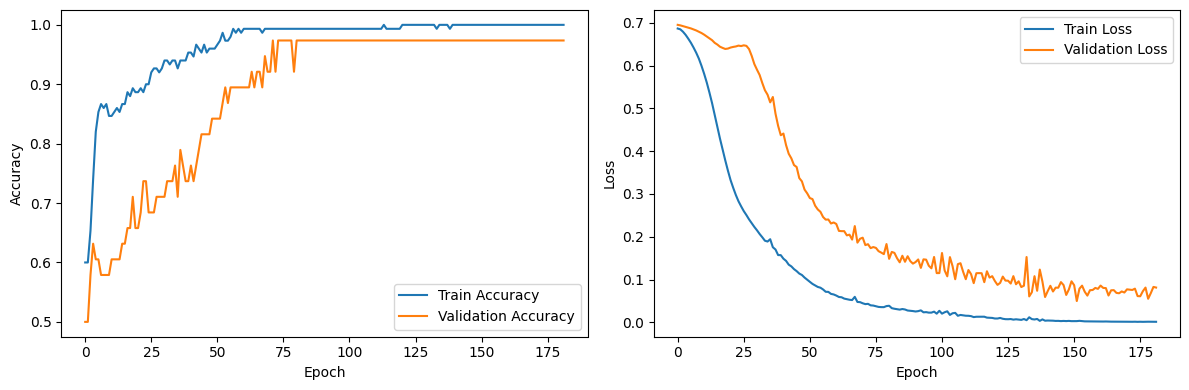

In [ ]:
 #Plot accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Plot precision, recall, and F1 score
plt.figure(figsize=(6, 4))
plt.plot(history.history['precision'], label='Precision')
plt.plot(history.history['recall'], label='Recall')
plt.plot(history.history['f1'], label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.tight_layout()
plt.show()

KeyError: ignored

<Figure size 600x400 with 0 Axes>

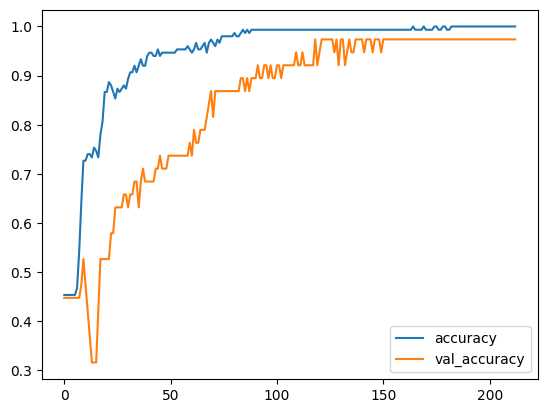

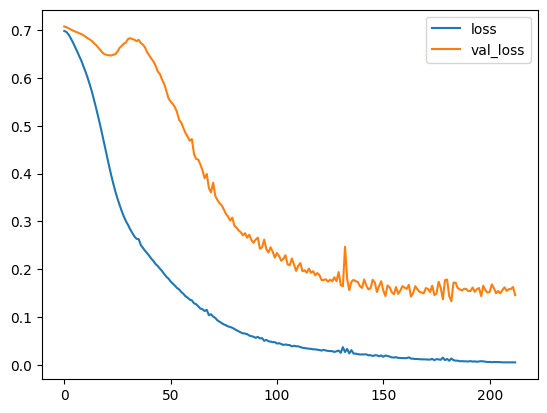

In [ ]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [ ]:
model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 13ms/step - loss: 0.2250 - accuracy: 0.9167


[0.2250031679868698, 0.9166666865348816]

#Normal ML Tools


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

#1 Logistic regression

In [ ]:
clf = LogisticRegression()

#Train Model
clf.fit(X_train, y_train)

ValueError: ignored

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create the Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model's performance
# ... (use the evaluation steps mentioned in the previous response)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred_rf)
print("Accuracy:", accuracy)

# Evaluate precision
precision = precision_score(y_test, y_pred_rf, average="macro")
print("Precision:", precision)

# Evaluate recall
recall = recall_score(y_test, y_pred_rf, average="macro")
print("Recall:", recall)

# Evaluate F1-score
f1 = f1_score(y_test, y_pred_rf, average="macro")
print("F1-score:", f1)

Accuracy: 0.9333333333333333
Precision: 0.8148148148148148
Recall: 0.8148148148148148
F1-score: 0.8148148148148148


In [ ]:
# show % of samples per classe
def show_classes_distribution(y):
    n_samples = len(y)
    labels = np.unique(y)
    counts = pd.value_counts(y) / n_samples

    df = pd.DataFrame({'classe': labels, 'percent': counts})
    # counts.plot.bar(x='counts', y='classe', rot=0)
    ax = sns.barplot(x='classe', y="percent", data=df)

# Evaluation Strategy

In [ ]:
def evaluate_model(model, model_name, X, y):
    X_train, X_test, y_train, y_true = train_test_split(X, y, test_size = 0.25, random_state=1)

    X_train_scaled = preprocessing.scale(X_train)
    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test)

    acc = accuracy_score(y_true, y_pred)
    f_measure = f1_score(y_true, y_pred, average='macro')
    mat = confusion_matrix(y_true, y_pred)

    print('************************************************************************************************')
    print(model_name, ' accuracy: ', acc)
    print(model_name, ' f-measure: ', f_measure)
    print(model_name, ' matrix confusion: ')
    print(mat)

    cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=1)
    scores = cross_val_score(model, X, y, cv=cv, scoring='f1_macro')

    print(model_name, ' scores by cv: ', scores)
    print(model_name, ' scores (mean)', np.average(scores))

# Generate dummy variables

In [ ]:
def get_encoded_data(data):
    vars_to_dummy = np.array(data.select_dtypes(include=['object', 'bool']).columns)
    new_data = pd.get_dummies(data, columns=vars_to_dummy, dummy_na=True)
    new_data = new_data.fillna(0)

    return new_data

# Unbalance Strategy - Oversampling (SMOTE - Synthetic Minority Over-sampling Technique)

In [ ]:
def get_oversampled_data(X, y):
    sm = SMOTE(sampling_strategy='auto', random_state=7)

    # Fit the model to generate the data.
    X_new, y_new = sm.fit_sample(X, y)

    return X_new, y_new

# Dimensionality Reduction by Feature Selection

The code used for feature selection is: https://github.com/jundongl/scikit-feature/blob/master/skfeature/function/similarity_based/lap_score.py
the method scores the features, so it's necessary choose the m-best features in the ranking
in this experiment the ideal (empirical) top of features is 50

In [ ]:
def construct_W(X, **kwargs):
    """
    Construct the affinity matrix W through different ways
    Notes
    -----
    if kwargs is null, use the default parameter settings;
    if kwargs is not null, construct the affinity matrix according to parameters in kwargs
    Input
    -----
    X: {numpy array}, shape (n_samples, n_features)
        input data
    kwargs: {dictionary}
        parameters to construct different affinity matrix W:
        y: {numpy array}, shape (n_samples, 1)
            the true label information needed under the 'supervised' neighbor mode
        metric: {string}
            choices for different distance measures
            'euclidean' - use euclidean distance
            'cosine' - use cosine distance (default)
        neighbor_mode: {string}
            indicates how to construct the graph
            'knn' - put an edge between two nodes if and only if they are among the
                    k nearest neighbors of each other (default)
            'supervised' - put an edge between two nodes if they belong to same class
                    and they are among the k nearest neighbors of each other
        weight_mode: {string}
            indicates how to assign weights for each edge in the graph
            'binary' - 0-1 weighting, every edge receives weight of 1 (default)
            'heat_kernel' - if nodes i and j are connected, put weight W_ij = exp(-norm(x_i - x_j)/2t^2)
                            this weight mode can only be used under 'euclidean' metric and you are required
                            to provide the parameter t
            'cosine' - if nodes i and j are connected, put weight cosine(x_i,x_j).
                        this weight mode can only be used under 'cosine' metric
        k: {int}
            choices for the number of neighbors (default k = 5)
        t: {float}
            parameter for the 'heat_kernel' weight_mode
        fisher_score: {boolean}
            indicates whether to build the affinity matrix in a fisher score way, in which W_ij = 1/n_l if yi = yj = l;
            otherwise W_ij = 0 (default fisher_score = false)
        reliefF: {boolean}
            indicates whether to build the affinity matrix in a reliefF way, NH(x) and NM(x,y) denotes a set of
            k nearest points to x with the same class as x, and a different class (the class y), respectively.
            W_ij = 1 if i = j; W_ij = 1/k if x_j \in NH(x_i); W_ij = -1/(c-1)k if x_j \in NM(x_i, y) (default reliefF = false)
    Output
    ------
    W: {sparse matrix}, shape (n_samples, n_samples)
        output affinity matrix W
    """

    # default metric is 'cosine'
    if 'metric' not in kwargs.keys():
        kwargs['metric'] = 'cosine'

    # default neighbor mode is 'knn' and default neighbor size is 5
    if 'neighbor_mode' not in kwargs.keys():
        kwargs['neighbor_mode'] = 'knn'
    if kwargs['neighbor_mode'] == 'knn' and 'k' not in kwargs.keys():
        kwargs['k'] = 5
    if kwargs['neighbor_mode'] == 'supervised' and 'k' not in kwargs.keys():
        kwargs['k'] = 5
    if kwargs['neighbor_mode'] == 'supervised' and 'y' not in kwargs.keys():
        print ('Warning: label is required in the supervised neighborMode!!!')
        exit(0)

    # default weight mode is 'binary', default t in heat kernel mode is 1
    if 'weight_mode' not in kwargs.keys():
        kwargs['weight_mode'] = 'binary'
    if kwargs['weight_mode'] == 'heat_kernel':
        if kwargs['metric'] != 'euclidean':
            kwargs['metric'] = 'euclidean'
        if 't' not in kwargs.keys():
            kwargs['t'] = 1
    elif kwargs['weight_mode'] == 'cosine':
        if kwargs['metric'] != 'cosine':
            kwargs['metric'] = 'cosine'

    # default fisher_score and reliefF mode are 'false'
    if 'fisher_score' not in kwargs.keys():
        kwargs['fisher_score'] = False
    if 'reliefF' not in kwargs.keys():
        kwargs['reliefF'] = False

    n_samples, n_features = np.shape(X)

    # choose 'knn' neighbor mode
    if kwargs['neighbor_mode'] == 'knn':
        k = kwargs['k']
        if kwargs['weight_mode'] == 'binary':
            if kwargs['metric'] == 'euclidean':
                # compute pairwise euclidean distances
                D = pairwise_distances(X)
                D **= 2
                # sort the distance matrix D in ascending order
                dump = np.sort(D, axis=1)
                idx = np.argsort(D, axis=1)
                # choose the k-nearest neighbors for each instance
                idx_new = idx[:, 0:k+1]
                G = np.zeros((n_samples*(k+1), 3))
                G[:, 0] = np.tile(np.arange(n_samples), (k+1, 1)).reshape(-1)
                G[:, 1] = np.ravel(idx_new, order='F')
                G[:, 2] = 1
                # build the sparse affinity matrix W
                W = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
                bigger = np.transpose(W) > W
                W = W - W.multiply(bigger) + np.transpose(W).multiply(bigger)
                return W

            elif kwargs['metric'] == 'cosine':
                # normalize the data first
                X_normalized = np.power(np.sum(X*X, axis=1), 0.5)
                for i in range(n_samples):
                    X[i, :] = X[i, :]/max(1e-12, X_normalized[i])
                # compute pairwise cosine distances
                D_cosine = np.dot(X, np.transpose(X))
                # sort the distance matrix D in descending order
                dump = np.sort(-D_cosine, axis=1)
                idx = np.argsort(-D_cosine, axis=1)
                idx_new = idx[:, 0:k+1]
                G = np.zeros((n_samples*(k+1), 3))
                G[:, 0] = np.tile(np.arange(n_samples), (k+1, 1)).reshape(-1)
                G[:, 1] = np.ravel(idx_new, order='F')
                G[:, 2] = 1
                # build the sparse affinity matrix W
                W = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
                bigger = np.transpose(W) > W
                W = W - W.multiply(bigger) + np.transpose(W).multiply(bigger)
                return W

        elif kwargs['weight_mode'] == 'heat_kernel':
            t = kwargs['t']
            # compute pairwise euclidean distances
            D = pairwise_distances(X)
            D **= 2
            # sort the distance matrix D in ascending order
            dump = np.sort(D, axis=1)
            idx = np.argsort(D, axis=1)
            idx_new = idx[:, 0:k+1]
            dump_new = dump[:, 0:k+1]
            # compute the pairwise heat kernel distances
            dump_heat_kernel = np.exp(-dump_new/(2*t*t))
            G = np.zeros((n_samples*(k+1), 3))
            G[:, 0] = np.tile(np.arange(n_samples), (k+1, 1)).reshape(-1)
            G[:, 1] = np.ravel(idx_new, order='F')
            G[:, 2] = np.ravel(dump_heat_kernel, order='F')
            # build the sparse affinity matrix W
            W = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
            bigger = np.transpose(W) > W
            W = W - W.multiply(bigger) + np.transpose(W).multiply(bigger)
            return W

        elif kwargs['weight_mode'] == 'cosine':
            # normalize the data first
            X_normalized = np.power(np.sum(X*X, axis=1), 0.5)
            for i in range(n_samples):
                    X[i, :] = X[i, :]/max(1e-12, X_normalized[i])
            # compute pairwise cosine distances
            D_cosine = np.dot(X, np.transpose(X))
            # sort the distance matrix D in ascending order
            dump = np.sort(-D_cosine, axis=1)
            idx = np.argsort(-D_cosine, axis=1)
            idx_new = idx[:, 0:k+1]
            dump_new = -dump[:, 0:k+1]
            G = np.zeros((n_samples*(k+1), 3))
            G[:, 0] = np.tile(np.arange(n_samples), (k+1, 1)).reshape(-1)
            G[:, 1] = np.ravel(idx_new, order='F')
            G[:, 2] = np.ravel(dump_new, order='F')
            # build the sparse affinity matrix W
            W = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
            bigger = np.transpose(W) > W
            W = W - W.multiply(bigger) + np.transpose(W).multiply(bigger)
            return W

    # choose supervised neighborMode
    elif kwargs['neighbor_mode'] == 'supervised':
        k = kwargs['k']
        # get true labels and the number of classes
        y = kwargs['y']
        label = np.unique(y)
        n_classes = np.unique(y).size
        # construct the weight matrix W in a fisherScore way, W_ij = 1/n_l if yi = yj = l, otherwise W_ij = 0
        if kwargs['fisher_score'] is True:
            W = lil_matrix((n_samples, n_samples))
            for i in range(n_classes):
                class_idx = (y == label[i])
                class_idx_all = (class_idx[:, np.newaxis] & class_idx[np.newaxis, :])
                W[class_idx_all] = 1.0/np.sum(np.sum(class_idx))
            return W

        # construct the weight matrix W in a reliefF way, NH(x) and NM(x,y) denotes a set of k nearest
        # points to x with the same class as x, a different class (the class y), respectively. W_ij = 1 if i = j;
        # W_ij = 1/k if x_j \in NH(x_i); W_ij = -1/(c-1)k if x_j \in NM(x_i, y)
        if kwargs['reliefF'] is True:
            # when xj in NH(xi)
            G = np.zeros((n_samples*(k+1), 3))
            id_now = 0
            for i in range(n_classes):
                class_idx = np.column_stack(np.where(y == label[i]))[:, 0]
                D = pairwise_distances(X[class_idx, :])
                D **= 2
                idx = np.argsort(D, axis=1)
                idx_new = idx[:, 0:k+1]
                n_smp_class = (class_idx[idx_new[:]]).size
                if len(class_idx) <= k:
                    k = len(class_idx) - 1
                G[id_now:n_smp_class+id_now, 0] = np.tile(class_idx, (k+1, 1)).reshape(-1)
                G[id_now:n_smp_class+id_now, 1] = np.ravel(class_idx[idx_new[:]], order='F')
                G[id_now:n_smp_class+id_now, 2] = 1.0/k
                id_now += n_smp_class
            W1 = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
            # when i = j, W_ij = 1
            for i in range(n_samples):
                W1[i, i] = 1
            # when x_j in NM(x_i, y)
            G = np.zeros((n_samples*k*(n_classes - 1), 3))
            id_now = 0
            for i in range(n_classes):
                class_idx1 = np.column_stack(np.where(y == label[i]))[:, 0]
                X1 = X[class_idx1, :]
                for j in range(n_classes):
                    if label[j] != label[i]:
                        class_idx2 = np.column_stack(np.where(y == label[j]))[:, 0]
                        X2 = X[class_idx2, :]
                        D = pairwise_distances(X1, X2)
                        idx = np.argsort(D, axis=1)
                        idx_new = idx[:, 0:k]
                        n_smp_class = len(class_idx1)*k
                        G[id_now:n_smp_class+id_now, 0] = np.tile(class_idx1, (k, 1)).reshape(-1)
                        G[id_now:n_smp_class+id_now, 1] = np.ravel(class_idx2[idx_new[:]], order='F')
                        G[id_now:n_smp_class+id_now, 2] = -1.0/((n_classes-1)*k)
                        id_now += n_smp_class
            W2 = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
            bigger = np.transpose(W2) > W2
            W2 = W2 - W2.multiply(bigger) + np.transpose(W2).multiply(bigger)
            W = W1 + W2
            return W

        if kwargs['weight_mode'] == 'binary':
            if kwargs['metric'] == 'euclidean':
                G = np.zeros((n_samples*(k+1), 3))
                id_now = 0
                for i in range(n_classes):
                    class_idx = np.column_stack(np.where(y == label[i]))[:, 0]
                    # compute pairwise euclidean distances for instances in class i
                    D = pairwise_distances(X[class_idx, :])
                    D **= 2
                    # sort the distance matrix D in ascending order for instances in class i
                    idx = np.argsort(D, axis=1)
                    idx_new = idx[:, 0:k+1]
                    n_smp_class = len(class_idx)*(k+1)
                    G[id_now:n_smp_class+id_now, 0] = np.tile(class_idx, (k+1, 1)).reshape(-1)
                    G[id_now:n_smp_class+id_now, 1] = np.ravel(class_idx[idx_new[:]], order='F')
                    G[id_now:n_smp_class+id_now, 2] = 1
                    id_now += n_smp_class
                # build the sparse affinity matrix W
                W = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
                bigger = np.transpose(W) > W
                W = W - W.multiply(bigger) + np.transpose(W).multiply(bigger)
                return W

            if kwargs['metric'] == 'cosine':
                # normalize the data first
                X_normalized = np.power(np.sum(X*X, axis=1), 0.5)
                for i in range(n_samples):
                    X[i, :] = X[i, :]/max(1e-12, X_normalized[i])
                G = np.zeros((n_samples*(k+1), 3))
                id_now = 0
                for i in range(n_classes):
                    class_idx = np.column_stack(np.where(y == label[i]))[:, 0]
                    # compute pairwise cosine distances for instances in class i
                    D_cosine = np.dot(X[class_idx, :], np.transpose(X[class_idx, :]))
                    # sort the distance matrix D in descending order for instances in class i
                    idx = np.argsort(-D_cosine, axis=1)
                    idx_new = idx[:, 0:k+1]
                    n_smp_class = len(class_idx)*(k+1)
                    G[id_now:n_smp_class+id_now, 0] = np.tile(class_idx, (k+1, 1)).reshape(-1)
                    G[id_now:n_smp_class+id_now, 1] = np.ravel(class_idx[idx_new[:]], order='F')
                    G[id_now:n_smp_class+id_now, 2] = 1
                    id_now += n_smp_class
                # build the sparse affinity matrix W
                W = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
                bigger = np.transpose(W) > W
                W = W - W.multiply(bigger) + np.transpose(W).multiply(bigger)
                return W

        elif kwargs['weight_mode'] == 'heat_kernel':
            G = np.zeros((n_samples*(k+1), 3))
            id_now = 0
            for i in range(n_classes):
                class_idx = np.column_stack(np.where(y == label[i]))[:, 0]
                # compute pairwise cosine distances for instances in class i
                D = pairwise_distances(X[class_idx, :])
                D **= 2
                # sort the distance matrix D in ascending order for instances in class i
                dump = np.sort(D, axis=1)
                idx = np.argsort(D, axis=1)
                idx_new = idx[:, 0:k+1]
                dump_new = dump[:, 0:k+1]
                t = kwargs['t']
                # compute pairwise heat kernel distances for instances in class i
                dump_heat_kernel = np.exp(-dump_new/(2*t*t))
                n_smp_class = len(class_idx)*(k+1)
                G[id_now:n_smp_class+id_now, 0] = np.tile(class_idx, (k+1, 1)).reshape(-1)
                G[id_now:n_smp_class+id_now, 1] = np.ravel(class_idx[idx_new[:]], order='F')
                G[id_now:n_smp_class+id_now, 2] = np.ravel(dump_heat_kernel, order='F')
                id_now += n_smp_class
            # build the sparse affinity matrix W
            W = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
            bigger = np.transpose(W) > W
            W = W - W.multiply(bigger) + np.transpose(W).multiply(bigger)
            return W

        elif kwargs['weight_mode'] == 'cosine':
            # normalize the data first
            X_normalized = np.power(np.sum(X*X, axis=1), 0.5)
            for i in range(n_samples):
                X[i, :] = X[i, :]/max(1e-12, X_normalized[i])
            G = np.zeros((n_samples*(k+1), 3))
            id_now = 0
            for i in range(n_classes):
                class_idx = np.column_stack(np.where(y == label[i]))[:, 0]
                # compute pairwise cosine distances for instances in class i
                D_cosine = np.dot(X[class_idx, :], np.transpose(X[class_idx, :]))
                # sort the distance matrix D in descending order for instances in class i
                dump = np.sort(-D_cosine, axis=1)
                idx = np.argsort(-D_cosine, axis=1)
                idx_new = idx[:, 0:k+1]
                dump_new = -dump[:, 0:k+1]
                n_smp_class = len(class_idx)*(k+1)
                G[id_now:n_smp_class+id_now, 0] = np.tile(class_idx, (k+1, 1)).reshape(-1)
                G[id_now:n_smp_class+id_now, 1] = np.ravel(class_idx[idx_new[:]], order='F')
                G[id_now:n_smp_class+id_now, 2] = np.ravel(dump_new, order='F')
                id_now += n_smp_class
            # build the sparse affinity matrix W
            W = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
            bigger = np.transpose(W) > W
            W = W - W.multiply(bigger) + np.transpose(W).multiply(bigger)
            return W

In [ ]:
# in this function the feature selection is performed by
# laplacian score, so the top features will be selected
def lap_score(X):
    """
    This function implements the laplacian score feature selection, steps are as follows:
    1. Construct the affinity matrix W if it is not specified
    2. For the r-th feature, we define fr = X(:,r), D = diag(W*ones), ones = [1,...,1]', L = D - W
    3. Let fr_hat = fr - (fr'*D*ones)*ones/(ones'*D*ones)
    4. Laplacian score for the r-th feature is score = (fr_hat'*L*fr_hat)/(fr_hat'*D*fr_hat)
    Input
    -----
    X: {numpy array}, shape (n_samples, n_features)
        input data
    kwargs: {dictionary}
        W: {sparse matrix}, shape (n_samples, n_samples)
            input affinity matrix
    Output
    ------
    score: {numpy array}, shape (n_features,)
        laplacian score for each feature
    Reference
    ---------
    He, Xiaofei et al. "Laplacian Score for Feature Selection." NIPS 2005.
    """

    # construct the affinity matrix W
    W = construct_W(X)

    # build the diagonal D matrix from affinity matrix W
    D = np.array(W.sum(axis=1))
    L = W
    tmp = np.dot(np.transpose(D), X)
    D = diags(np.transpose(D), [0])
    Xt = np.transpose(X)
    t1 = np.transpose(np.dot(Xt, D.todense()))
    t2 = np.transpose(np.dot(Xt, L.todense()))
    # compute the numerator of Lr
    D_prime = np.sum(np.multiply(t1, X), 0) - np.multiply(tmp, tmp)/D.sum()
    # compute the denominator of Lr
    L_prime = np.sum(np.multiply(t2, X), 0) - np.multiply(tmp, tmp)/D.sum()
    # avoid the denominator of Lr to be 0
    D_prime[D_prime < 1e-12] = 10000

    # compute laplacian score for all features
    score = 1 - np.array(np.multiply(L_prime, 1/D_prime))[0, :]
    return np.transpose(score)

def feature_ranking(score):
    """
    Rank features in ascending order according to their laplacian scores, the smaller the laplacian score is, the more
    important the feature is
    """
    idx = np.argsort(score, 0)
    return idx

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import accuracy_score
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.cluster import KMeans

def lap_score(X):
    # Compute the nearest neighbors graph
    nn = NearestNeighbors(n_neighbors=5, metric='euclidean')
    nn.fit(X)
    knn_graph = nn.kneighbors_graph(X)

    # Compute the degree matrix
    degree_matrix = np.diag(np.array(knn_graph.sum(axis=1)).flatten())

    # Compute the Laplacian matrix
    laplacian_matrix = degree_matrix - knn_graph

    # Compute the Laplacian scores
    laplacian_scores = np.sum(laplacian_matrix, axis=1)

    return laplacian_scores

def best_map(l1, l2):
    """
    Permute labels of l2 to match l1 as much as possible
    """
    if len(l1) != len(l2):
        print("L1.shape must == L2.shape")
        exit(0)

    label1 = np.unique(l1)
    n_class1 = len(label1)

    label2 = np.unique(l2)
    n_class2 = len(label2)

    n_class = max(n_class1, n_class2)
    G = np.zeros((n_class, n_class))

    for i in range(0, n_class1):
        for j in range(0, n_class2):
            ss = l1 == label1[i]
            tt = l2 == label2[j]
            G[i, j] = np.count_nonzero(ss & tt)

    # Use linear_sum_assignment instead of linear_assignment
    A = linear_sum_assignment(-G)

    new_l2 = np.zeros(l2.shape)
    for i in range(0, n_class2):
        new_l2[l2 == label2[A[1][i]]] = label1[A[0][i]]
    return new_l2.astype(int)

def get_reduced_data(X, top):
    feat_scores = lap_score(X)
    idx = np.argsort(feat_scores, 0)

    # Get the Laplacian scores of the features
    feature_scores = feat_scores[idx[::-1]]

    # Get the indices of the top 'top' features
    top_feature_indices = idx[::-1][:top]

    # Return the reduced data and the indices of the selected features
    return X[:, top_feature_indices], top_feature_indices

# Load your dataset (replace 'your_dataset.csv' with the actual filename)
# data = pd.read_csv('your_dataset.csv')

# Assuming 'status' is the target variable
X = data_origin.drop(columns=['name','status'])
y = data_origin['status']

# Data Preprocessing - Feature Scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Get reduced training data and the indices of the selected features
top_features = 7
X_train_reduced, selected_feature_indices = get_reduced_data(X_train, top_features)

# Get the names of the selected features
selected_feature_names = X.columns[selected_feature_indices]

# Visualize the Laplacian scores of the top features
plt.bar(range(top_features), feature_scores)
plt.xlabel('Feature Index')
plt.ylabel('Laplacian Score')
plt.title('Laplacian Scores of Top Features')
plt.xticks(range(top_features), selected_feature_names, rotation=90)
plt.show()

# Evaluation
n_clusters = len(np.unique(y_train))
nmi, acc = evaluation(X_train_reduced, n_clusters, y_train)
print("Normalized Mutual Information (NMI): {:.4f}".format(nmi))
print("Accuracy (ACC): {:.4f}".format(acc))


IndexError: ignored

In [ ]:
pip install scikit-feature


ERROR: Could not find a version that satisfies the requirement scikit-feature (from versions: none)
ERROR: No matching distribution found for scikit-feature


In [ ]:
import scipy.io
#from skfeature.function.similarity_based import lap_score
#from skfeature.utility import construct_W
from skfeature.utility import unsupervised_evaluation


def main():
    # load data
    #mat = scipy.io.loadmat('../data/COIL20.mat')
    #X = mat['X']    # data
    #X = X.astype(float)
   # y = mat['Y']    # label
    #y = y[:, 0]

    # construct affinity matrix
    kwargs_W = {"metric": "euclidean", "neighbor_mode": "knn", "weight_mode": "heat_kernel", "k": 5, 't': 1}
    W = construct_W.construct_W(X, **kwargs_W)

    # obtain the scores of features
    score = lap_score.lap_score(X, W=W)

    # sort the feature scores in an ascending order according to the feature scores
    idx = lap_score.feature_ranking(score)

    # perform evaluation on clustering task
    num_fea = 100    # number of selected features
    num_cluster = 20    # number of clusters, it is usually set as the number of classes in the ground truth

    # obtain the dataset on the selected features
    selected_features = X[:, idx[0:num_fea]]

    # perform kmeans clustering based on the selected features and repeats 20 times
    nmi_total = 0
    acc_total = 0
    for i in range(0, 20):
        nmi, acc = unsupervised_evaluation.evaluation(X_selected=selected_features, n_clusters=num_cluster, y=y)
        nmi_total += nmi
        acc_total += acc

    # output the average NMI and average ACC
    print('NMI:', float(nmi_total)/20)
    print('ACC:', float(acc_total)/20)

if __name__ == '__main__':
    main()

ModuleNotFoundError: ignored

# Get Reduced and Balanced Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors

def lap_score(X):
    # Compute the nearest neighbors graph
    nn = NearestNeighbors(n_neighbors=5, metric='euclidean')
    nn.fit(X)
    knn_graph = nn.kneighbors_graph(X)

    # Compute the degree matrix
    degree_matrix = np.diag(np.array(knn_graph.sum(axis=1)).flatten())

    # Compute the Laplacian matrix
    laplacian_matrix = degree_matrix - knn_graph

    # Compute the transpose of the Laplacian matrix
    laplacian_matrix_t = laplacian_matrix.transpose()

    # Compute the Laplacian scores
    laplacian_scores = np.sum(laplacian_matrix_t, axis=1)

    return laplacian_scores

def get_reduced_data(X, top):
    n_features = X.shape[1]
    if top > n_features:
        top = n_features

    feat_scores = lap_score(X)
    idx = np.argsort(feat_scores, 0)

    # Get the Laplacian scores of the features
    feature_scores = feat_scores[idx[::-1]]

    # Get the indices of the top 'top' features
    top_feature_indices = idx[::-1][:top]

    # Return the reduced data and the Laplacian scores of the top features
    return X[:, top_feature_indices], feature_scores[:top]

# Load your dataset (replace 'your_dataset.csv' with the actual filename)
# data = pd.read_csv('your_dataset.csv')

# Assuming 'status' is the target variable
X = data_origin.drop(columns=['name', 'status'])
y = data_origin['status']

# Data Preprocessing - Feature Scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Get reduced training data and Laplacian scores of features
top_features = 7
X_train_reduced, feature_scores = get_reduced_data(X_train, top_features)

# Visualize the Laplacian scores of the top features
plt.bar(range(top_features), feature_scores)
plt.xlabel('Feature Index')
plt.ylabel('Laplacian Score')
plt.title('Laplacian Scores of Top Features')
plt.show()


IndexError: ignored

In [ ]:
def get_reduced_data(X, top):
    feat_scores = lap_score(X.values)
    idx = np.argsort(feat_scores, 0)

    return X.iloc[:, idx[0:top]]

In [ ]:
# the strategy used is the oversampling (resampling the minority classes)
# the technique used is: SMOTE (Synthetic Minority Over-sampling Technique)
# ref: https://towardsdatascience.com/having-an-imbalanced-dataset-here-is-how-you-can-solve-it-1640568947eb

pd.set_option('display.max_columns', 10)
# encoding categorical variables
y_raw = data_origin['status']
X_raw = data_origin.drop(['name'], axis=1)

X_raw_encoded = get_encoded_data(X_raw)
X_raw_encoded

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),...,DFA,spread1,spread2,D2,PPE
0,119.992,157.302,74.997,0.00784,0.00007,...,0.815285,-4.813031,0.266482,2.301442,0.284654
1,122.400,148.650,113.819,0.00968,0.00008,...,0.819521,-4.075192,0.335590,2.486855,0.368674
2,116.682,131.111,111.555,0.01050,0.00009,...,0.825288,-4.443179,0.311173,2.342259,0.332634
3,116.676,137.871,111.366,0.00997,0.00009,...,0.819235,-4.117501,0.334147,2.405554,0.368975
4,116.014,141.781,110.655,0.01284,0.00011,...,0.823484,-3.747787,0.234513,2.332180,0.410335
...,...,...,...,...,...,...,...,...,...,...,...
190,174.188,230.978,94.261,0.00459,0.00003,...,0.657899,-6.538586,0.121952,2.657476,0.133050
191,209.516,253.017,89.488,0.00564,0.00003,...,0.683244,-6.195325,0.129303,2.784312,0.168895
192,174.688,240.005,74.287,0.01360,0.00008,...,0.655683,-6.787197,0.158453,2.679772,0.131728
193,198.764,396.961,74.904,0.00740,0.00004,...,0.643956,-6.744577,0.207454,2.138608,0.123306


In [ ]:
pip install -U imbalanced-learn

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_raw, y_raw)

# X_encoded = pd.get_dummies(X)
# X_encoded.dtypes
#X_new, y_new = get_oversampled_data(X_raw_encoded, y_raw)
#print(X_new.shape)

top_features = 10
X_new_reduced = get_reduced_data(X_resampled, top_features)
X_new_reduced
X_new_reduced.to_csv('reduced_dataset.csv', index=False)


unbalanced data


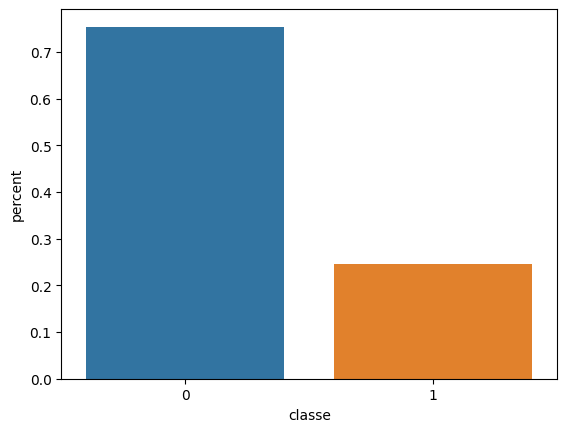

In [ ]:
print('unbalanced data')
show_classes_distribution(y_raw)

balanced data


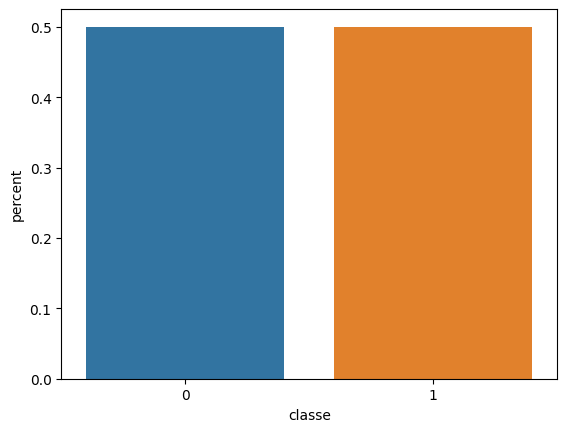

In [ ]:
print('balanced data')
show_classes_distribution(y_resampled)

In [ ]:
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

# Load the reduced dataset containing only selected features
reduced_dataset = pd.DataFrame(data=X_new_reduced)
reduced_dataset.head()

,MDVP:Flo(Hz),MDVP:Fhi(Hz),MDVP:Fo(Hz),HNR,DFA,spread1,D2,RPDE,spread2,PPE
0,74.997,157.302,119.992,21.033,0.815285,-4.813031,2.301442,0.414783,0.266482,0.284654
1,113.819,148.650,122.400,19.085,0.819521,-4.075192,2.486855,0.458359,0.335590,0.368674
2,111.555,131.111,116.682,20.651,0.825288,-4.443179,2.342259,0.429895,0.311173,0.332634
3,111.366,137.871,116.676,20.644,0.819235,-4.117501,2.405554,0.434969,0.334147,0.368975
4,110.655,141.781,116.014,19.649,0.823484,-3.747787,2.332180,0.417356,0.234513,0.410335


# Testing models

In [ ]:
X_new = X_resampled
y_new = y_resampled
knn = KNeighborsClassifier(n_neighbors = 3)
evaluate_model(knn, 'knn - balanced', X_new, y_new)
evaluate_model(knn, 'knn - balanced and reduced', X_new_reduced, y_new)
evaluate_model(knn, 'knn - unbalance', X_raw_encoded, y_raw)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


************************************************************************************************
knn - balanced  accuracy:  0.527027027027027
knn - balanced  f-measure:  0.34513274336283184
knn - balanced  matrix confusion: 
[[ 0 35]
 [ 0 39]]
knn - balanced  scores by cv:  [0.76264368 0.80804496 0.64365833 0.79513889 0.84366577 0.77864358
 0.77940754 0.8640553  0.77864358 0.75600962]
knn - balanced  scores (mean) 0.7809911225942849
************************************************************************************************
knn - balanced and reduced  accuracy:  0.527027027027027
knn - balanced and reduced  f-measure:  0.34513274336283184
knn - balanced and reduced  matrix confusion: 
[[ 0 35]
 [ 0 39]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


knn - balanced and reduced  scores by cv:  [0.76264368 0.80804496 0.64365833 0.79513889 0.84366577 0.77864358
 0.77940754 0.8640553  0.77864358 0.75600962]
knn - balanced and reduced  scores (mean) 0.7809911225942849
************************************************************************************************
knn - unbalance  accuracy:  0.3877551020408163
knn - unbalance  f-measure:  0.38749999999999996
knn - unbalance  matrix confusion: 
[[10  2]
 [28  9]]
knn - unbalance  scores by cv:  [0.78333333 0.68688671 0.7367406  0.86551724 0.6637931  0.66152363
 0.78333333 0.82589286 0.70676692 0.86551724]
knn - unbalance  scores (mean) 0.7579304959328093


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


In [ ]:
# decision tree
dt = tree.DecisionTreeClassifier()
evaluate_model(dt, 'Decision Tree - balanced', X_new, y_new)
evaluate_model(dt, 'Decision Tree - balanced and reduced', X_new_reduced, y_new)
evaluate_model(dt, 'Decision Tree - unbalance', X_raw_encoded, y_raw)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


************************************************************************************************
Decision Tree - balanced  accuracy:  0.527027027027027
Decision Tree - balanced  f-measure:  0.34513274336283184
Decision Tree - balanced  matrix confusion: 
[[ 0 35]
 [ 0 39]]
Decision Tree - balanced  scores by cv:  [0.8640553  0.96561772 0.89804147 0.91486291 0.8614098  0.86436782
 0.8640553  0.96585648 0.84586357 0.86190476]
Decision Tree - balanced  scores (mean) 0.8906035130977086
************************************************************************************************
Decision Tree - balanced and reduced  accuracy:  0.527027027027027
Decision Tree - balanced and reduced  f-measure:  0.34513274336283184
Decision Tree - balanced and reduced  matrix confusion: 
[[ 0 35]
 [ 0 39]]
Decision Tree - balanced and reduced  scores by cv:  [0.8640553  0.94820018 0.91486291 0.89804147 0.84366577 0.86436782
 0.8640553  0.98287373 0.86342593 0.87898659]
Decision Tree - balanced and reduced 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [ ]:
# Random Forest
rf = RandomForestClassifier(max_depth=2, random_state=0)
evaluate_model(rf, 'RandomForest - balanced', X_new, y_new)
evaluate_model(rf, 'RandomForest - balanced and reduced', X_new_reduced, y_new)
evaluate_model(rf, 'RandomForest - unbalance', X_raw_encoded, y_raw)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


************************************************************************************************
RandomForest - balanced  accuracy:  0.527027027027027
RandomForest - balanced  f-measure:  0.34513274336283184
RandomForest - balanced  matrix confusion: 
[[ 0 35]
 [ 0 39]]
RandomForest - balanced  scores by cv:  [0.75705882 0.89464286 0.81269841 0.84728214 0.74368687 0.75416667
 0.80804496 0.88121944 0.82647059 0.75746714]
RandomForest - balanced  scores (mean) 0.8082737900460121
************************************************************************************************
RandomForest - balanced and reduced  accuracy:  0.527027027027027
RandomForest - balanced and reduced  f-measure:  0.34513274336283184
RandomForest - balanced and reduced  matrix confusion: 
[[ 0 35]
 [ 0 39]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForest - balanced and reduced  scores by cv:  [0.77553409 0.87623614 0.81269841 0.84728214 0.72769953 0.75416667
 0.82440476 0.88121944 0.80804496 0.74068554]
RandomForest - balanced and reduced  scores (mean) 0.8047971689167636
************************************************************************************************
RandomForest - unbalance  accuracy:  0.7551020408163265
RandomForest - unbalance  f-measure:  0.43023255813953487
RandomForest - unbalance  matrix confusion: 
[[ 0 12]
 [ 0 37]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForest - unbalance  scores by cv:  [0.7367406  0.60685484 0.79365079 0.81195757 0.8030303  0.73541384
 0.79827586 0.76923077 0.71111111 0.78333333]
RandomForest - unbalance  scores (mean) 0.7549599018818112


In [ ]:
# SVM
svm = svm.SVC()
evaluate_model(svm, 'SVM - balanced', X_new, y_new)
evaluate_model(svm, 'SVM - balanced and reduced', X_new_reduced, y_new)
evaluate_model(svm, 'SVM - unbalance', X_raw_encoded, y_raw)

AttributeError: ignored

In [ ]:
# MLP
mlp = MLPClassifier(hidden_layer_sizes=(50, 20, 10), random_state=1)
evaluate_model(mlp, 'MLP - balanced', X_new, y_new)
evaluate_model(mlp, 'MLP - balanced and reduced', X_new_reduced, y_new)
evaluate_model(mlp, 'MLP - unbalance', X_raw_encoded, y_raw)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


************************************************************************************************
MLP - balanced  accuracy:  0.527027027027027
MLP - balanced  f-measure:  0.34513274336283184
MLP - balanced  matrix confusion: 
[[ 0 35]
 [ 0 39]]


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

MLP - balanced  scores by cv:  [0.57431457 0.71186441 0.61823529 0.49020737 0.66996107 0.38972306
 0.62701149 0.72494172 0.57627119 0.65352449]
MLP - balanced  scores (mean) 0.6036054668930422


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


************************************************************************************************
MLP - balanced and reduced  accuracy:  0.527027027027027
MLP - balanced and reduced  f-measure:  0.34513274336283184
MLP - balanced and reduced  matrix confusion: 
[[ 0 35]
 [ 0 39]]


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

MLP - balanced and reduced  scores by cv:  [0.55613426 0.69482759 0.60286801 0.50790912 0.65144231 0.58741259
 0.66013825 0.51411765 0.5591954  0.34090909]
MLP - balanced and reduced  scores (mean) 0.5674954259617467


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


************************************************************************************************
MLP - unbalance  accuracy:  0.24489795918367346
MLP - unbalance  f-measure:  0.19672131147540983
MLP - unbalance  matrix confusion: 
[[12  0]
 [37  0]]
MLP - unbalance  scores by cv:  [0.42647059 0.40909091 0.43478261 0.43478261 0.43478261 0.44285714
 0.42647059 0.70454545 0.41791045 0.40909091]
MLP - unbalance  scores (mean) 0.45407838659031546


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


# Conclusions

After the experiments it's possible to observes that:
1) the RandomForest get the best performance
2) the balance of classes improve the performance
3) it's necessary try others strategies to increase de performance
4) the objects are classified in the C and E classe